#Imports

In [1]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [10]:
# %%capture
!git clone https://github.com/IDEA-Research/GroundingDINO.git

!cd /content/GroundingDINO && git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!cd /content/GroundingDINO && pip install -q -e .

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


In [11]:
# %%capture
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0v7ef9oc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0v7ef9oc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [4]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

--2023-07-28 15:56:40--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.21, 13.224.2.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   181MB/s    in 17s     

2023-07-28 15:56:57 (145 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

--2023-07-28 15:56:57--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/611591640/f221e500-c2

In [13]:
import os
import supervision as sv
import shutil
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
from typing import *


In [17]:
%cd GroundingDINO

/content/GroundingDINO


In [18]:
import cv2
import numpy as np
import supervision as sv

import torch
import torchvision

from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GroundingDINO config and checkpoint
GROUNDING_DINO_CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT_PATH = "groundingdino_swint_ogc.pth"

# Segment-Anything checkpoint
SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
# Predict classes and hyper-param for GroundingDINO
#SOURCE_IMAGE_PATH = "./assets/demo2.jpg"

In [26]:
%cd ..

/content


In [27]:
class GroundedDINOSAM:
    def __init__(self, box_threshold=0.25, text_threshold=0.25, nms_threshold=0.8):
        # Building GroundingDINO inference model
        self.grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

        # Building SAM Model and SAM Predictor
        self.sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
        self.sam.to(device=DEVICE)
        self.sam_predictor = SamPredictor(self.sam)
        self.BOX_THRESHOLD = box_threshold
        self.TEXT_THRESHOLD = text_threshold
        self.NMS_THRESHOLD = nms_threshold


    def segment(self, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
        self.sam_predictor.set_image(image)
        result_masks = []
        for box in xyxy:
            masks, scores, logits = self.sam_predictor.predict(
                box=box,
                multimask_output=True
            )
            index = np.argmax(scores)
            result_masks.append(masks[index])

        return np.array(result_masks)


    def inference(self, image_path, label):
        classes = [label]
        image = np.array(Image.open(image_path))
        open_cv_image = image[:, :, ::-1].copy()

        detections = self.grounding_dino_model.predict_with_classes(
            image=open_cv_image,
            classes=classes,
            box_threshold=self.BOX_THRESHOLD,
            text_threshold=self.TEXT_THRESHOLD
        )

        nms_idx = torchvision.ops.nms(
            torch.from_numpy(detections.xyxy),
            torch.from_numpy(detections.confidence),
            self.NMS_THRESHOLD
        ).numpy().tolist()

        detections.xyxy = detections.xyxy[nms_idx]
        detections.confidence = detections.confidence[nms_idx]
        detections.class_id = detections.class_id[nms_idx]
        detections.mask = self.segment(
            image=image,
            xyxy=detections.xyxy
        )

        return detections

# Running Grounded SAM

## Test

In [ ]:
detect_segment_model = GroundedDINOSAM()

final text_encoder_type: bert-base-uncased


In [ ]:
img_path = "/content/atest_folder/000.jpg"
dets = detect_segment_model.inference(img_path, "toy food on the ground")

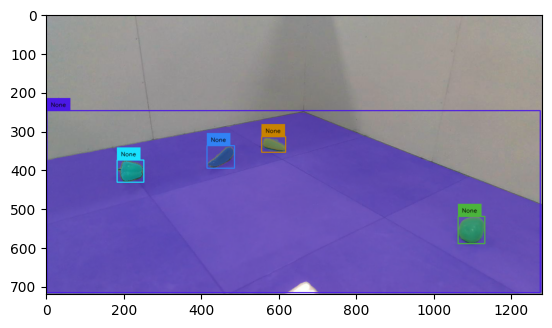

In [ ]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

annotated_image = mask_annotator.annotate(scene=cv2.imread(img_path).copy(), detections=dets)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=dets)

plt.imshow(annotated_image)
plt.show()

## Running grounded sam on COCO annots

In [28]:
from pycocotools.coco import COCO
import pycocotools._mask as mask_tool

import zipfile
import json

In [29]:
HOME = os.getcwd()

def extract_zip(filepath, extract_path):
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(filepath, 'r') as zip:
        zip.extractall(extract_path)

def achive_zip(filepath, result_path):
    fantasy_zip = zipfile.ZipFile('{}.zip'.format(result_path), 'w')
    for folder, subfolders, files in os.walk(filepath):
        for file in files:
            fantasy_zip.write(os.path.join(folder, file),
            os.path.relpath(os.path.join(folder, file), filepath),
                            compress_type = zipfile.ZIP_DEFLATED)
    fantasy_zip.close()

In [63]:
from tqdm import tqdm

def choose_prompt(item, category):
    # for HF==1 only labels comment until return category
    if "tag2text_text" in item.keys():
        prompt = item["tag2text_text_with_class"]
        if "tag2text_text_hf" in item.keys():
            if item["tag2text_text_hf"] > item["tag2text_text_with_class_hf"]:
                prompt = item["tag2text_text"]
        return prompt
    return category

def inference_grounding_sam(images_dir_path, coco_annots_path, output_dir_path):
    os.makedirs(output_dir_path, exist_ok=True)

    coco = COCO(coco_annots_path)
    detect_segment_model = GroundedDINOSAM()

    bbox_predictions = []
    seg_predictions = []
    for key in tqdm(coco.anns.keys(), total=len(coco.anns.keys())):
        img_num = coco.anns[key]['image_id']
        image_filename = coco.imgs[img_num]['file_name']
        category_id = coco.anns[key]['category_id']
        category = coco.cats[category_id]['name']

        prompt = choose_prompt(coco.anns[key], category)

        # print(*[image_filename, category, prompt])
        img_path = os.path.join(images_dir_path, image_filename)
        detections = detect_segment_model.inference(img_path, prompt)

        bboxs = []
        for i in range(len(detections)):
            bb = [int(e) for e in detections.xyxy[i]]
            bb[2] -= bb[0]
            bb[3] -= bb[1]

            bboxs.append({
            "image_id": img_num,
            "category_id": category_id,
            "bbox": bb,
            "score": float(detections.confidence[i])
            })

        segs = []
        for i in range(len(detections)):
            mask = detections.mask[i]

            h, w = mask.shape
            binary_mask = mask.squeeze().astype(np.uint8)

            # Find the contours of the mask
            contours, hierarchy = cv2.findContours(binary_mask,
                                                cv2.RETR_EXTERNAL,
                                                cv2.CHAIN_APPROX_SIMPLE)

            # Get the largest contour based on area
            largest_contour = max(contours, key=cv2.contourArea)

            # Get the segmentation mask for object
            segmentation = largest_contour.flatten().tolist()

            rles = mask_tool.frPyObjects([segmentation], h, w)

            bb = [int(e) for e in detections.xyxy[i]]
            bb[2] -= bb[0]
            bb[3] -= bb[1]

            segs.append({
                "image_id": img_num,
                "category_id": category_id,
                "segmentation": {
                    "size": rles[0]['size'],
                    "counts": rles[0]['counts'].decode("utf-8")
                },
                "area": int(cv2.contourArea(largest_contour)),
                "bbox": bb,
                "iscrowd": 0,
                "score": float(detections.confidence[i])
            })

        bbox_predictions.extend(bboxs)
        seg_predictions.extend(segs)
        # break

    with open(os.path.join(output_dir_path, "bbox_predictions.json"), 'w') as f:
        json.dump(bbox_predictions, f, indent=4)
    with open(os.path.join(output_dir_path, "seg_predictions.json"), 'w') as f:
        json.dump(seg_predictions, f, indent=4)

    print("Completed!")


In [23]:
extract_zip("/content/strl.zip", "/content/strl_images")

### T2T w/ HF == 1

In [51]:
IMAGES_DIR_PATH = '/content/strl_images'
COCO_ANNOTS_PATH = '/content/indoor_part+captioning_hf1.json'
OUTPUT_DIR_PATH = '/content/strl_hf1_results'

In [52]:
inference_grounding_sam(IMAGES_DIR_PATH, COCO_ANNOTS_PATH, OUTPUT_DIR_PATH)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
final text_encoder_type: bert-base-uncased


100%|██████████| 69/69 [02:49<00:00,  2.46s/it]

Completed!


In [53]:
!zip -r {OUTPUT_DIR_PATH}.zip {OUTPUT_DIR_PATH}

updating: content/strl_hf1_results/ (stored 0%)
updating: content/strl_hf1_results/bbox_predictions.json (deflated 87%)
updating: content/strl_hf1_results/seg_predictions.json (deflated 72%)


In [54]:
from google.colab import files
files.download(f"{OUTPUT_DIR_PATH}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Indoor w/ HF==1 only labels

In [64]:
IMAGES_DIR_PATH = '/content/strl_images'
COCO_ANNOTS_PATH = '/content/indoor_part+captioning_hf1.json'
OUTPUT_DIR_PATH = '/content/strl_hf1_results_only_labels'

In [65]:
inference_grounding_sam(IMAGES_DIR_PATH, COCO_ANNOTS_PATH, OUTPUT_DIR_PATH)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
final text_encoder_type: bert-base-uncased


100%|██████████| 69/69 [02:55<00:00,  2.54s/it]

Completed!


In [66]:
!zip -r {OUTPUT_DIR_PATH}.zip {OUTPUT_DIR_PATH}

  adding: content/strl_hf1_results_only_labels/ (stored 0%)
  adding: content/strl_hf1_results_only_labels/bbox_predictions.json (deflated 87%)
  adding: content/strl_hf1_results_only_labels/seg_predictions.json (deflated 71%)


In [67]:
from google.colab import files
files.download(f"{OUTPUT_DIR_PATH}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Indoor w/o T2T

In [57]:
IMAGES_DIR_PATH = '/content/strl_images'
COCO_ANNOTS_PATH = '/content/indoor.json'
OUTPUT_DIR_PATH = '/content/indoor_results'

In [58]:
inference_grounding_sam(IMAGES_DIR_PATH, COCO_ANNOTS_PATH, OUTPUT_DIR_PATH)

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
final text_encoder_type: bert-base-uncased


100%|██████████| 1412/1412 [59:36<00:00,  2.53s/it]


Completed!


In [59]:
!zip -r {OUTPUT_DIR_PATH}.zip {OUTPUT_DIR_PATH}

  adding: content/indoor_results/ (stored 0%)
  adding: content/indoor_results/bbox_predictions.json (deflated 93%)
  adding: content/indoor_results/seg_predictions.json (deflated 89%)


In [60]:
from google.colab import files
files.download(f"{OUTPUT_DIR_PATH}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluate metrics

In [35]:
!git clone https://github.com/Areson251/segmentation_by_text.git

Cloning into 'segmentation_by_text'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 54 (delta 13), reused 46 (delta 10), pack-reused 0
Receiving objects: 100% (54/54), 2.71 MiB | 9.85 MiB/s, done.
Resolving deltas: 100% (13/13), done.


### T2T w/ HF == 1

In [55]:
!python /content/segmentation_by_text/metrics.py \
 /content/indoor_part+captioning_hf1.json \
 /content/strl_hf1_results/seg_predictions.json

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.348
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.618
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### Indoor w/ HF==1 only labels

In [68]:
!python /content/segmentation_by_text/metrics.py \
 /content/indoor_part+captioning_hf1.json \
 /content/strl_hf1_results_only_labels/seg_predictions.json

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.753
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.789
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### Indoor w/o T2T

In [62]:
!python /content/segmentation_by_text/metrics.py \
 /content/indoor_crowd0_fixed.json \
 /content/indoor_results/seg_predictions.json

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.61s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.395
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# ByteTrack

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

/content
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 38.56 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERRO

In [ ]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [ ]:
!pip install onemetric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.0 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install loguru

  Using cached loguru-0.7.0-py3-none-any.whl (59 kB)


In [ ]:
!pip install lap

  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628950 sha256=2df1ccff80ada5b684f5b6c7a4920e8e7b0571d23b255d25e8e16b89948ed1e4
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result


def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image


def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator


@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image

In [ ]:
from typing import List

import numpy as np

"""
BYTETracker does not assign tracker_id to existing bounding boxes but rather
predicts the next bounding box position based on previous one. Therefore, we
need to find a way to match our bounding boxes with predictions.

usage example:

byte_tracker = BYTETracker(BYTETrackerArgs())
for frame in frames:
    ...
    results = model(frame, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(),
        names=model.names)
    ...
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)
"""

# converts List[Detection] into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: List[Detection],
    tracks: List[STrack]
) -> List[Detection]:

    if not tracks:
        return []
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [ ]:
def detections2boxes(detections: List[Detection], with_confidence: bool = True) -> np.ndarray:
    return np.array([
        [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y,
            detection.confidence
        ] if with_confidence else [
            detection.rect.top_left.x,
            detection.rect.top_left.y,
            detection.rect.bottom_right.x,
            detection.rect.bottom_right.y
        ]
        for detection
        in detections
    ], dtype=float)

In [ ]:
def annotation_to_result(annotations):
    results = []
    for xyxy, mask, conf, class_id, _ in annotations:
        x1, y1, x2, y2 = xyxy
        res = [x1, y1, x2, y2, conf, class_id]
        results.append(res)
    return results

In [ ]:
@dataclass
class Annotator:
    background_color: Color
    text_color: Color
    frame_color: Color
    text_thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            # if tracker_id is not assigned skip annotation
            if detection.tracker_id is None:
                continue

            # draw rectangle
            annotated_image = draw_rect(annotated_image, detection.rect, self.frame_color)

            # calculate text dimensions
            size, _ = cv2.getTextSize(
                str(detection.tracker_id),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                thickness=self.text_thickness)
            width, height = size

            # calculate text background position
            center_x, center_y = detection.rect.bottom_center.int_xy_tuple
            x = center_x - width // 2
            y = center_y - height // 2 + 10

            # draw background
            annotated_image = draw_filled_rect(
                image=annotated_image,
                rect=Rect(x=x, y=y, width=width, height=height).pad(padding=5),
                color=self.background_color)

            # draw text
            annotated_image = draw_text(
                image=annotated_image,
                anchor=Point(x=x, y=y + height),
                text=str(detection.tracker_id),
                color=self.text_color,
                thickness=self.text_thickness)

        return annotated_image

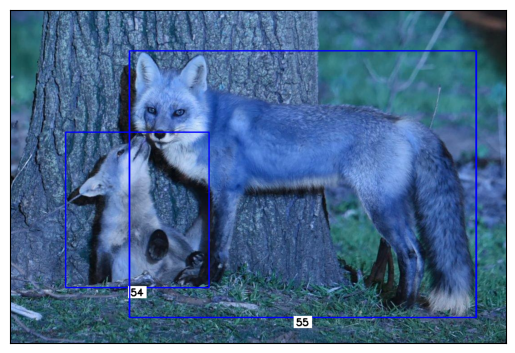

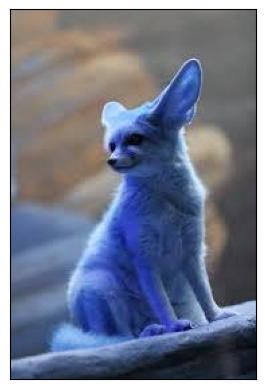

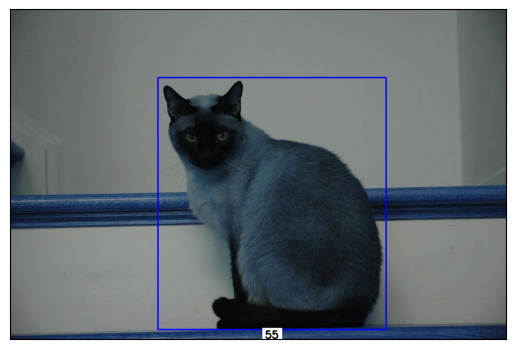

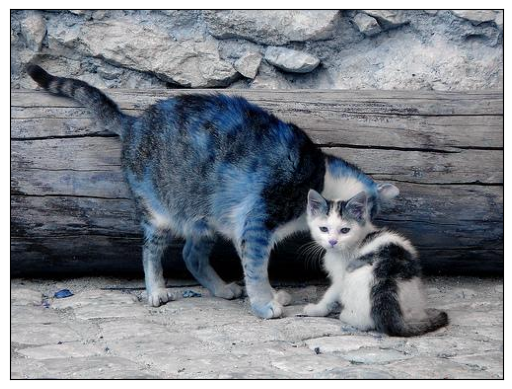

In [ ]:
byte_tracker = BYTETracker(BYTETrackerArgs())
byte_tracker.tracked_stracks

class_id_name_map = {0: "object"}

annotator = Annotator(background_color=Color(255, 255, 255),
                      text_color=Color(0, 0, 0),
                      frame_color=Color(255, 0, 0),
                      text_thickness=2)

image_names = sorted(list(dataset.images.keys()))[:SAMPLE_SIZE]
images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]

    results = annotation_to_result(annotations)
    detections = Detection.from_results(pred=results, names=class_id_name_map)
    # print(*detections, sep='\n')
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=image.shape,
        img_size=image.shape)
    # print(tracks)
    detections = match_detections_with_tracks(detections=detections, tracks=tracks)

    annotated_image = image.copy()
    annotated_image = annotator.annotate(
        image=annotated_image,
        detections=detections)

    plt.imshow(annotated_image)
    plt.xticks([])
    plt.yticks([])
    plt.show()


# Wrap everything